# 1. Project Definition <a id='definition'></a>


#### Introduction


#### Problem Definition


# 2. Importing packages and setup

Importing libraries and setting up spark session

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
%matplotlib inline

# pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, col, countDistinct, sum, avg, when, desc, asc, isnan, count, sort_array 
from pyspark.sql.functions import split, rank, concat,lit, stddev, max, min
from pyspark.sql.types import StringType, IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# create a Spark session
spark = SparkSession\
        .builder\
        .appName("Sparkify")\
        .getOrCreate()

#spark.conf.set("spark.sql.shuffle.partitions", 4)

# 3. Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## 3.1 Loading data

In [3]:
#Load data
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)

## 3.2 Exploring data

In [4]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
# Show top two rows of df dataframe
df.show(n=2,vertical = True)

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
-RECORD 1-----------------------------
 artist        | Five Iron Frenzy     
 auth          | Logged In            
 firstName     | Micah                
 gender        | M                    
 itemInSession | 79                   
 lastName      | Long    

In [6]:
# Print schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [7]:
# Total number of rows
df.count()

286500

In [8]:
# Total number of columns
len(df.columns)

18

In [9]:
# Print total number of distinct artists
print('Number of distinct artists:', df.select("artist").distinct().count())

# Show distinct "artists"
df.select("artist").distinct().show()

Number of distinct artists: 17656
+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [10]:
# Print total number of distinct songs
print('Number of distinct songs:', df.select("song").distinct().count())

# Show distinct "songs"
df.select("song").distinct().show()

Number of distinct songs: 58481
+--------------------+
|                song|
+--------------------+
|Never Gonna Be Al...|
|         TULENLIEKKI|
|      Underwaterboys|
|Saor (Free)/News ...|
|               New E|
|The Geeks Were Right|
|              Heaven|
|      Call Me Manana|
|             Push It|
|Cool Monsoon (Wea...|
|The Fun Lovin' Cr...|
|Turn Your Lights ...|
|          Growing Up|
|          Positivity|
|         Miracle Man|
|        I'm The Drug|
|I've Just Seen A ...|
|            Anna May|
|All The Things Sh...|
|    Blue Suede Shoes|
+--------------------+
only showing top 20 rows



In [11]:
# Show top 20 most played songs
df.select(['ts','song']).groupby('song').count().sort('count', ascending = False).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|58392|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



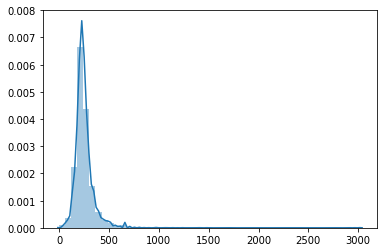

In [12]:
#Plot song 'length' distribution in seconds
sns.distplot(df.select('length').toPandas().dropna());

In [13]:
# Print total number of distinct pages
print('Number of distinct pages:', df.select("page").distinct().count())

# Count number of user per distinct "pages" - Most seen pages by users
df.select(["userId","page"]).groupby("page").count().sort("count", ascending = False).show()

Number of distinct pages: 22
+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+
only showing top 20 rows



> As we can see in the table above, the "NextSong" page has 18 times more pageviews than the homepage itself (second in the table), marking with a large margin the users most frequent activity. Next we will see the remaining activities, removing the influence of the "NextSong" page.

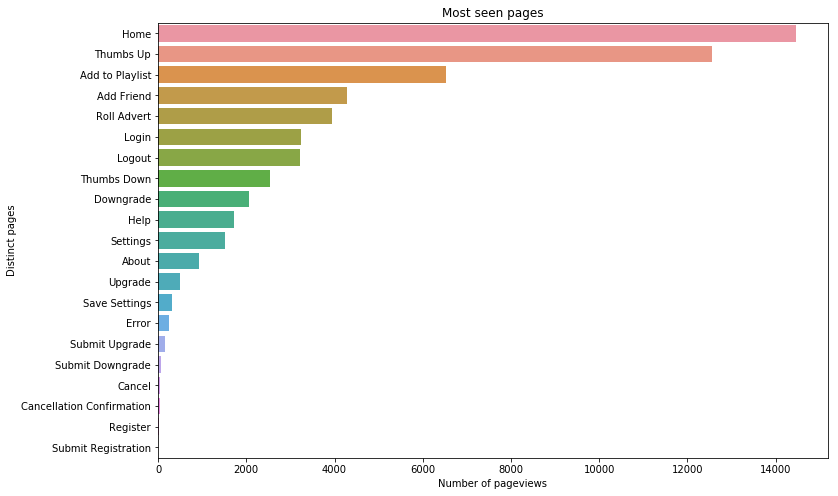

In [14]:
# Plot the most seen pages
most_seen_pages = df.select(["userId","page"]).groupby("page").count().sort("count", ascending = False).toPandas()

plt.figure(figsize=(12, 8))
ax = sns.barplot(x="count", y="page", data= most_seen_pages[most_seen_pages.page != 'NextSong'])
ax.set_title("Most seen pages")
ax.set_xlabel("Number of pageviews")
ax.set_ylabel("Distinct pages");

In [15]:
# Show distinct authentication status
df.select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+



In [16]:
# Count number of user per each authentication status
df.select('userId','auth').dropDuplicates().groupby('auth').count().show()

+----------+-----+
|      auth|count|
+----------+-----+
|Logged Out|    1|
| Cancelled|   52|
|     Guest|    1|
| Logged In|  225|
+----------+-----+



> When users are *Logged Out* or are *Guests* do not have a `userId`defined

In [17]:
# Count number of user per distinct "levels"
df.select(["userId","level"]).dropDuplicates().groupby("level").count().show()

# although a user can start with a free account and upgrade to a paid account later

+-----+-----+
|level|count|
+-----+-----+
| free|  196|
| paid|  166|
+-----+-----+



In [18]:
# Show distinct "methods"
df.select('method').distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [19]:
# Show distinct "status"
df.select(["userId","status"]).dropDuplicates().groupby("status").count().show()

+------+-----+
|status|count|
+------+-----+
|   307|  224|
|   404|  118|
|   200|  226|
+------+-----+



In [20]:
# Show total number of distinct users
df.select('userId').distinct().count()

226

In [21]:
# Show total number of distinct sessions
df.select('sessionId').distinct().count()

2354

In [22]:
# Count number of user by gender
df.select(["userId","gender"]).dropDuplicates().groupby("gender").count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|  null|    1|
|     M|  121|
+------+-----+



In [23]:
# Create 'state' column from spliting using 'location' information
df = df.withColumn('state', split(col('location'),',').getItem(1))

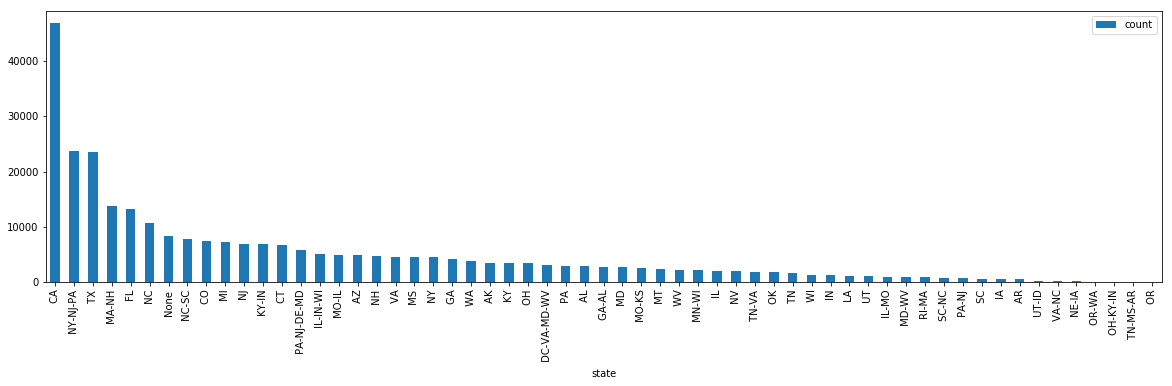

In [24]:
# Calculate the number of users in each state
users_per_state = df.select(['userId','state']).groupby('state').count().sort('count',ascending=False).toPandas()
users_per_state.plot(x = 'state', kind='bar',figsize=(20,5));

In [25]:
# Check for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0--------------
 artist        | 58392 
 auth          | 0     
 firstName     | 8346  
 gender        | 8346  
 itemInSession | 0     
 lastName      | 8346  
 length        | 58392 
 level         | 0     
 location      | 8346  
 method        | 0     
 page          | 0     
 registration  | 8346  
 sessionId     | 0     
 song          | 58392 
 status        | 0     
 ts            | 0     
 userAgent     | 8346  
 userId        | 0     
 state         | 8346  



> As we can see, all the attributes that concern the session variables (like *ts, status, sessionId, userId, itemInSession, page*) are complete. So apparently there is no invalid record.

> However, there seems to be a pattern in the missing values for the remaining variables.
* `artist`, `length` and `song` have 58 392 missing values;
* `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` have 8 346 missing values.

In [26]:
# Show 5 sessionIds where "artist" is a missing value
df.select(['sessionId','userId']).where(df.artist.isNull()).show(n=5)

+---------+------+
|sessionId|userId|
+---------+------+
|       29|    30|
|        8|     9|
|        8|     9|
|       53|    54|
|       53|    54|
+---------+------+
only showing top 5 rows



In [27]:
# Show all event of sessionId = 8 for userId = 9 (missing artist, length and song example)
df.where(df.sessionId == 8).where(df.userId == 9).sort('ts').toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,state
0,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
1,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
2,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
3,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
4,Britt Nicole,Logged In,Micah,M,83,Long,229.87710,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Walk On The Water,200,1538353146000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
5,None,Logged In,Micah,M,84,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1538331630000,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
6,Tesla,Logged In,Micah,M,85,Long,201.06404,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Gettin' Better,200,1538353375000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
7,None,Logged In,Micah,M,86,Long,NaN,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1538331630000,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
8,Florence + The Machine,Logged In,Micah,M,87,Long,168.64608,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,You've Got The Love,200,1538353576000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH
9,Ratatat,Logged In,Micah,M,88,Long,229.77261,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Swisha,200,1538353744000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,MA-NH


> Records with missing `artist`, `song` and `length` are records that are not related to music events. For instance, it occurs when the `page` is "Thumbs Up", "Thumbs Down", "Home", "Logout", "Roll Advert", "Add to Playlist", "Upgrade", and others. It is not an error and should not be removed or filled with some value. 


In [28]:
#Check for empty values
df.select([count(when(col(c)=='', c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0-------------
 artist        | 0    
 auth          | 0    
 firstName     | 0    
 gender        | 0    
 itemInSession | 0    
 lastName      | 0    
 length        | 0    
 level         | 0    
 location      | 0    
 method        | 0    
 page          | 0    
 registration  | 0    
 sessionId     | 0    
 song          | 0    
 status        | 0    
 ts            | 0    
 userAgent     | 0    
 userId        | 8346 
 state         | 0    



> The **8 346** events in which `firstName`, `gender`, `lastName`, `location`, `registration` and `userAgent` are null values correspond to scenarios in which:
* users did not give permissions to capture data, for instance, by refusing browser cookies
* the user is not identified, browsing the site without logging in.

> For these same scenarios a `userId` is not generated, appearing as empty as we can see with the image above. These records will be dropped in the steps. 

## 3.3 Cleaning data

In [29]:
# Drop rows with unregistered users
df = df.filter(df.userId != "")

In [30]:
# Check again for missing values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical = True)

-RECORD 0--------------
 artist        | 50046 
 auth          | 0     
 firstName     | 0     
 gender        | 0     
 itemInSession | 0     
 lastName      | 0     
 length        | 50046 
 level         | 0     
 location      | 0     
 method        | 0     
 page          | 0     
 registration  | 0     
 sessionId     | 0     
 song          | 50046 
 status        | 0     
 ts            | 0     
 userAgent     | 0     
 userId        | 0     
 state         | 0     



In [31]:
# get_date Function
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# get_hour Function
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour, IntegerType())

# get_day Function
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day, IntegerType())


In [32]:
# Convert timestamps to date
df = df.withColumn("date", get_date(df.ts))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state=' CA', date='2018-10-01 00:01:57')

In [33]:
# Convert timestamps to hour
df = df.withColumn("hour", get_hour(df.ts))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state=' CA', date='2018-10-01 00:01:57', hour=0)

In [34]:
# Convert timestamps to day of the month
df = df.withColumn("day", get_day(df.ts))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', state=' CA', date='2018-10-01 00:01:57', hour=0, day=1)

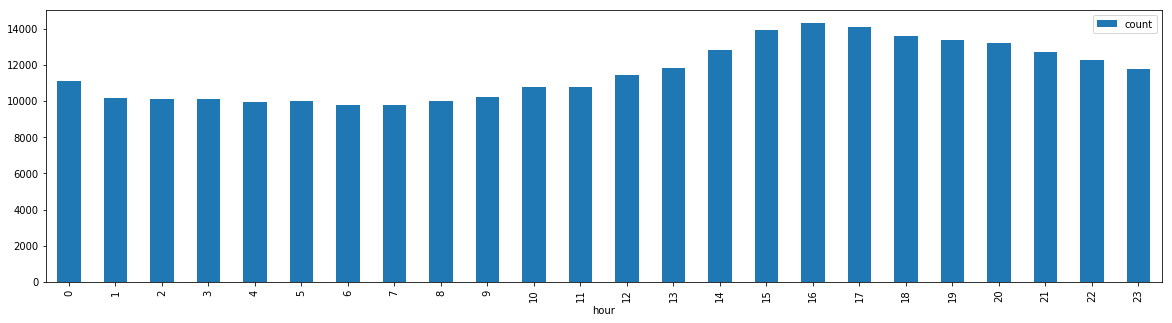

In [35]:
# Calculate the number of events per hour
events_per_hour = df.select(['userId','hour']).groupby('hour').count().sort('hour').toPandas()
events_per_hour.plot(x = 'hour', kind='bar',figsize=(20,5));

In [36]:
# Convert registration timestamp to date
df = df.withColumn("registration_date", get_date(df.registration))

# Convert registration timestamp to hour
df = df.withColumn("registration_hour", get_hour(df.registration))

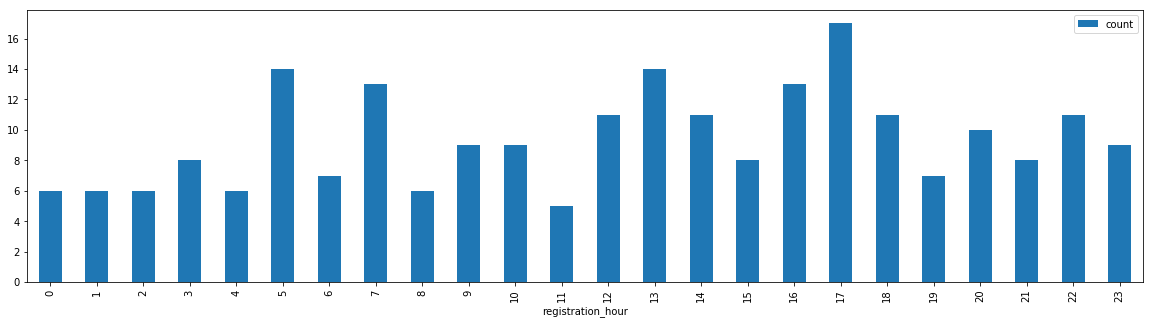

In [37]:
# Calculate the number of registations per hour
registration_per_hour = df.select(['userId','registration_hour']).dropDuplicates().groupby('registration_hour').count().sort('registration_hour').toPandas()
registration_per_hour.plot(x = 'registration_hour', kind='bar',figsize=(20,5));

# 4. Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

## 4.1 Define Churn events

The concept of churn must be interpreted and defined in the context of each product and business. In the case of the Sparkify service there are several events and behaviors that can be considered churn, or even demonstrate an intention to do so. They are:

* **"Cancellation Confirmation"** page -  page viewed when canceling the account, which can happen for both paid and free users
* **"Submit Downgrade"** page - page viewed when downgrading from a paid to a  free subscription. 
* **Users without visits for more than 6 months** - the frequency of visits is a metric that can also be used to classify users' engagement with the service. However, as the dataset only refers to a couple of months, this approach cannot be tested. 

Thus, I will create a column `Churn`and another `Downgrade` to use as label for the models. 

### 4.1.1 Churn as a "Confirm Cancellaion" event

In [38]:
# Function to identify churn events
is_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [39]:
# Create churn column 
df = df.withColumn("churn", is_churn_event("page"))

In [40]:
# Create a partitionated window by userID
windowval = Window.partitionBy("userId")

# Sum churn flag over user window
df = df.withColumn("Fchurn", sum("churn").over(windowval))

In [41]:
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', state=' CT', date='2018-10-08 12:58:54', hour=12, day=8, registration_date='2018-09-27 02:45:40', registration_hour=2, churn=0, Fchurn=0)

In [42]:
print('Number of users who have churned: {}'.\
      format(df.filter(df.Fchurn != 0).select('userId').dropDuplicates().count()))
print('Number of users who have not churned: {}'.\
      format(df.filter(df.Fchurn == 0).select('userId').dropDuplicates().count()))

Number of users who have churned: 52
Number of users who have not churned: 173


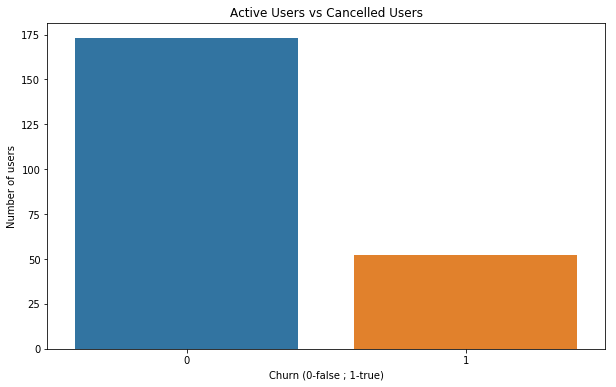

In [43]:
churn_count = df.select(['userId','Fchurn']).dropDuplicates().groupby('Fchurn').count().toPandas()

# Plot the number of active and churned users
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Fchurn", y="count", data=churn_count)
ax.set_title("Active Users vs Cancelled Users")
ax.set_xlabel("Churn (0-false ; 1-true)")
ax.set_ylabel("Number of users");

### 4.1.2 Churn as a "Submit Downgrade" event

In [44]:
# Function to identify downgrade events
is_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [45]:
# Create downgrade column 
df = df.withColumn("downgrade", is_downgrade_event("page"))

In [46]:
# Sum downgrade flag over user window
df = df.withColumn("Fdowngrade", sum("downgrade").over(windowval))

In [47]:
print('Number of users who have downgraded: {}'.\
      format(df.filter(df.Fdowngrade != 0).select('userId').dropDuplicates().count()))
print('Number of users who have not downgraded: {}'.\
      format(df.filter(df.Fdowngrade == 0).select('userId').dropDuplicates().count()))
print('Number of users with paid accounts: {}'.\
      format(df.select(['userId','level']).filter(df.level == 'paid').dropDuplicates().count()))

Number of users who have downgraded: 49
Number of users who have not downgraded: 176
Number of users with paid accounts: 165


In [48]:
# Create a partitionated window by userID ordered by descending ts
windowDesc = Window.partitionBy("userId").orderBy(col('ts').desc())

# Keep only the last record of each user
user_last_event = df.withColumn("rank", rank().over(windowDesc)).filter(col('rank') == 1).drop('rank')

In [49]:
# Check the number of user who have downgraded, and how many times
user_last_event["userId", "Fdowngrade"].dropDuplicates().groupby("Fdowngrade").count().show()

+----------+-----+
|Fdowngrade|count|
+----------+-----+
|         0|  176|
|         1|   37|
|         3|    2|
|         2|   10|
+----------+-----+



In [50]:
# Check the final level of user who have downgraded
user_last_event["userId", "Fdowngrade","level"].dropDuplicates().sort('Fdowngrade').groupby(["Fdowngrade","level"]).count().show()

+----------+-----+-----+
|Fdowngrade|level|count|
+----------+-----+-----+
|         0| free|   60|
|         0| paid|  116|
|         1| paid|   23|
|         1| free|   14|
|         2| paid|    4|
|         2| free|    6|
|         3| paid|    2|
+----------+-----+-----+



> Although there are **49 users who downgraded at least once**, when comparing these numbers with the final "level" of those same users, we see that 29 ended up subscribing to the paid service again. Since the upgrade and downgrade of service is very volatile, in which users can pass through the levels several times, and there is only a sample of 20 users who after downgrading maintained their free accounts, **we will not consider this as the main event to measure Churn**

## 4.2 Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Gender

In [51]:
# Check distribution by Gender
gender_count = df.select(["userId", "gender","Fchurn"]).dropDuplicates().groupby(["Fchurn", "gender"]).count().toPandas()
gender_count

,Fchurn,gender,count
0,0,F,84
1,1,M,32
2,1,F,20
3,0,M,89


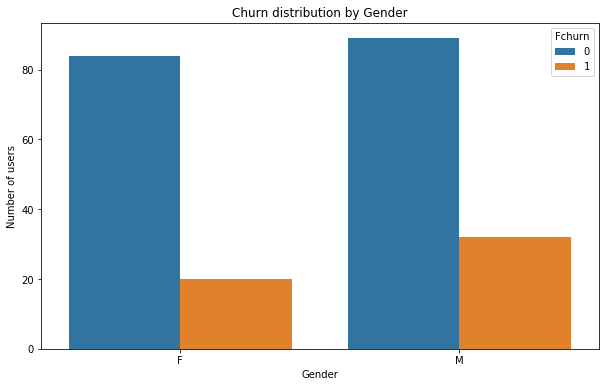

In [52]:
# Plot Churn distribution by Gender
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="gender", y="count", hue="Fchurn", data=gender_count)
ax.set_title("Churn distribution by Gender")
ax.set_xlabel("Gender")
ax.set_ylabel("Number of users");

> Obviously, the number of active customers is dominant as they represents 77% of the sample. However, as we can see the proportion of churns is slightly different between genders: **19.2% for Females and 26.4% for Males.**

### Level

In [53]:
# Check distribution by Level
level_count = df.select(["userId", "level","Fchurn"]).dropDuplicates().groupby(["Fchurn", "level"]).count().toPandas()
level_count

,Fchurn,level,count
0,1,paid,36
1,1,free,46
2,0,free,149
3,0,paid,129


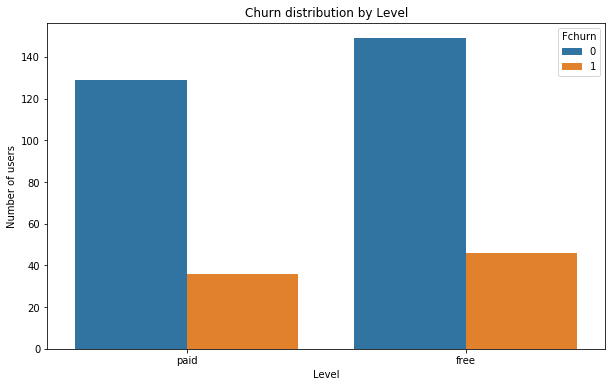

In [54]:
# Plot Churn distribution by Level
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="level", y="count", hue="Fchurn", data=level_count)
ax.set_title("Churn distribution by Level")
ax.set_xlabel("Level")
ax.set_ylabel("Number of users");

> In the case of the 2 possible levels, the number of churns is similarly distributed between the 2 groups: **21.8% churn for paid customers and 23.6% churn for free customers.**

### Location - State

In [55]:
# Check distribution by Location - state
users_per_state = df.select(["userId", "state","Fchurn"]).dropDuplicates().groupby(["Fchurn", "state"]).count().sort('count','state', ascending = False).toPandas()
users_per_state.head(25)

,Fchurn,state,count
0,0,CA,27
1,0,TX,13
2,0,FL,11
3,0,NY-NJ-PA,10
4,0,CT,7
5,0,NC-SC,6
6,1,CA,6
7,1,NY-NJ-PA,5
8,0,NC,5
9,0,MO-IL,5


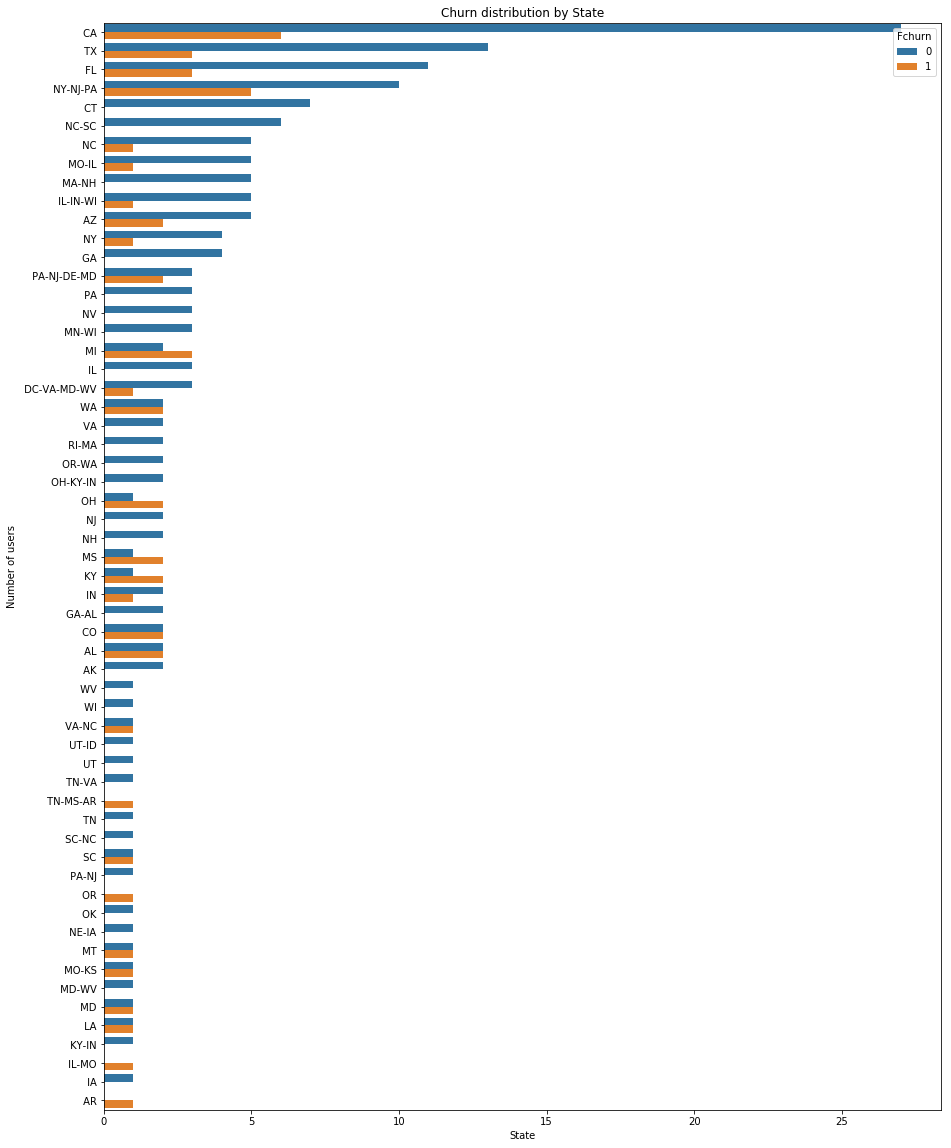

In [56]:
# Plot Churn distribution by Level
plt.figure(figsize=(15, 20))
ax = sns.barplot(x="count", y="state", hue="Fchurn", data = users_per_state)
ax.set_title("Churn distribution by State")
ax.set_xlabel("State")
ax.set_ylabel("Number of users");

> The churn rate differs between the different states. In the top 4 states with the most users, the churn percentages are:
* California (CA) - 18%
* Texas (TX) - 19%
* Florida (FL) - 21%
* New York/New Jersey (NY-NJ-PA) - 33%

> According to the bar graph most states have low Churn Rates, like Illinois (IL), and others even zero rates like Connecticut,North and South Carolina, Nevada and Virginia.

> A few examples have Churn Rate greater than 50%, they are: Michigan, Ohio, Mississippi and Kentucky

### Lenght

In [57]:
df.select(["Fchurn", "length"]).groupby(["Fchurn"])\
    .agg(avg("length").alias('mean_length'),
         stddev("length").alias("stddev_length"),
         max("length").alias("max_length"),
         min("length").alias("min_length")).show()

+------+------------------+------------------+----------+----------+
|Fchurn|       mean_length|     stddev_length|max_length|min_length|
+------+------------------+------------------+----------+----------+
|     0|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
|     1|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
+------+------------------+------------------+----------+----------+



> The lenght distribution of the two types of users (active and churned) is quite similar as it presents the average value, the standard deviation and the maximum value very close. The minimum value is the only indicator that is substantially higher for customers who have canceled the service.

### Pages

In [58]:
# Check distribution by Pages
pages_count = df.select(["userId", "page","Fchurn"]).groupby(["Fchurn", "page"]).count().sort('count', ascending = False).toPandas()
pages_count

,Fchurn,page,count
0,0,NextSong,191714
1,1,NextSong,36394
2,0,Thumbs Up,10692
3,0,Home,8410
4,0,Add to Playlist,5488
5,0,Add Friend,3641
6,0,Roll Advert,2966
7,0,Logout,2673
8,0,Thumbs Down,2050
9,1,Thumbs Up,1859


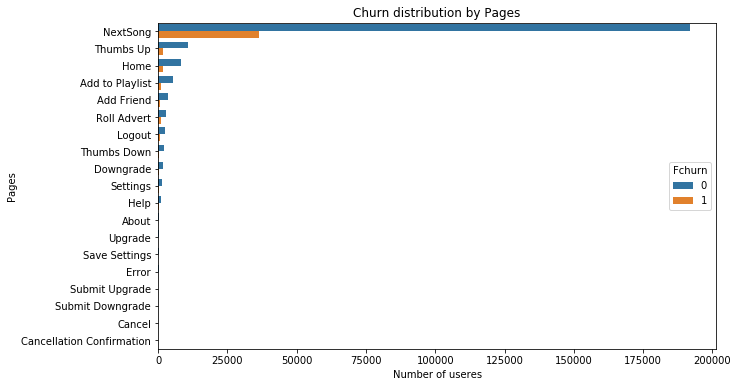

In [59]:
# Plot Churn distribution by Page
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="count", y="page", hue="Fchurn", data=pages_count)
ax.set_title("Churn distribution by Pages")
ax.set_xlabel("Number of useres")
ax.set_ylabel("Pages");

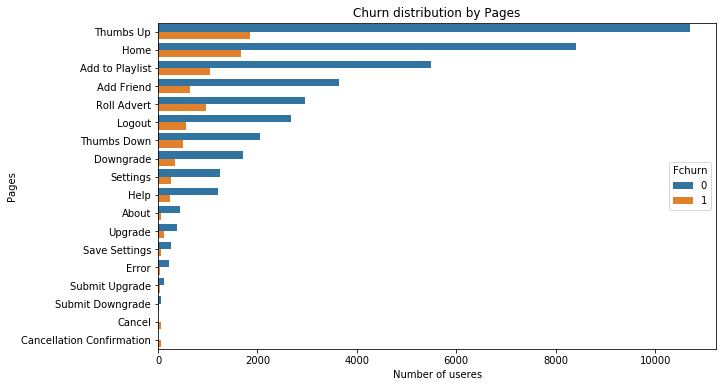

In [60]:
# Plot Churn distribution by Page, by removing the "NextSong" page 
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="count", y="page", hue="Fchurn", data=pages_count[pages_count['page']!="NextSong"])
ax.set_title("Churn distribution by Pages")
ax.set_xlabel("Number of useres")
ax.set_ylabel("Pages");

> Page Views are an indicator of the interactions and activities that users most perform on the platform. Moving on to the "NextSong" is clearly the most frequent action for both groups. Then there are the actions of "Thumbs Up" and visiting the Homepage, also for both.

> Users who cancel/churn do "Roll Advert" more often than active users.

#### Pages : Thumbs Up

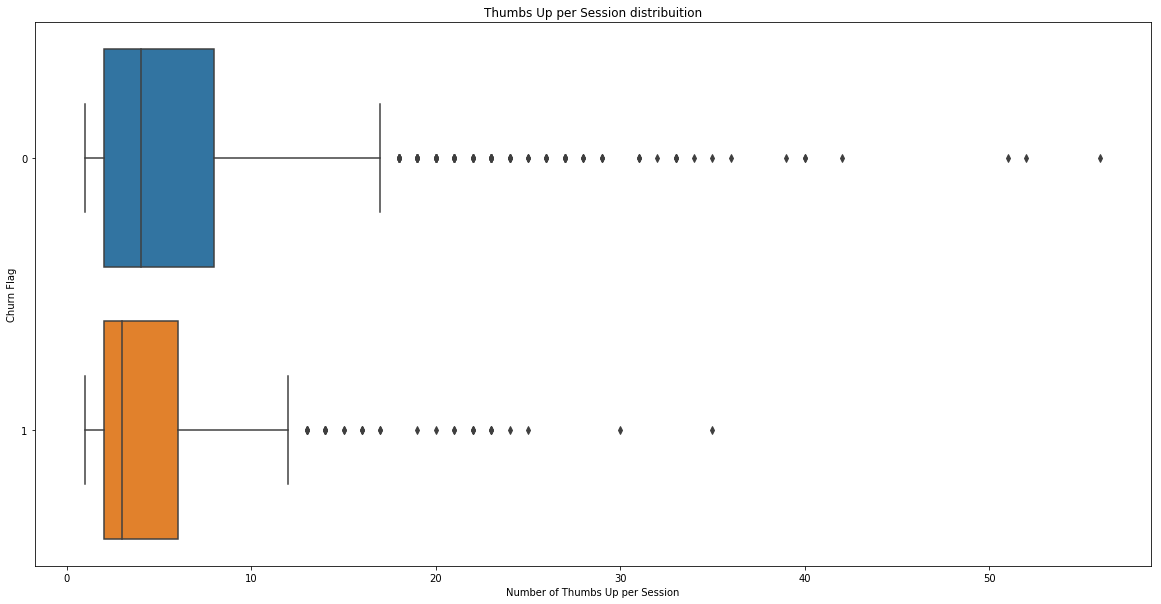

In [61]:
# Compare the number of Thumbs Up activity for active and churned users

thumbsup_count = df.filter(df['page'] == 'Thumbs Up').groupby("Fchurn", "sessionId").count().toPandas()


# Plot Thumbs Up activity per session for both segments

plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='count', y='Fchurn', orient="h", data = thumbsup_count)
ax.set_title("Thumbs Up per Session distribuition")
ax.set_xlabel("Number of Thumbs Up per Session")
ax.set_ylabel("Churn Flag");

> Customers who cancel/churn tend to give less Thumbs Up per session than active customers. This can be concluded because the limit values of all quadrants are lower (mean, median and maximum value).

#### Pages : Roll Advert 

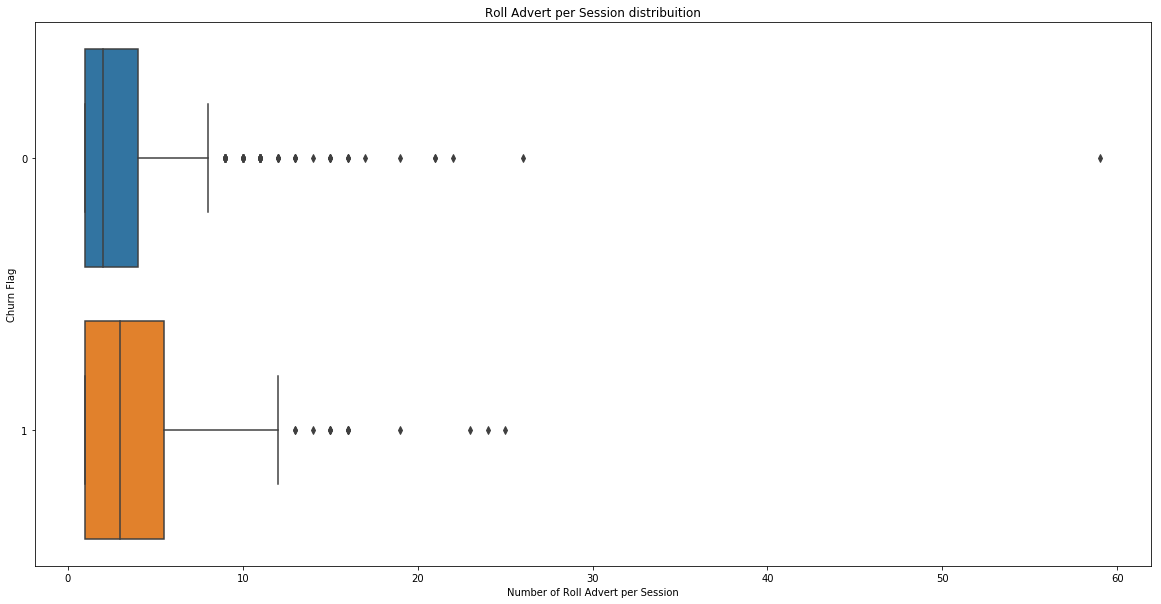

In [62]:
# Compare the number of Roll Advert activity for active and churned users

rolladvert_count = df.filter(df['page'] == 'Roll Advert').groupby("Fchurn", "sessionId").count().toPandas()


# Plot Thumbs Up activity per session for both segments

plt.figure(figsize=(20, 10))
ax = sns.boxplot(x='count', y='Fchurn', orient="h", data = rolladvert_count)
ax.set_title("Roll Advert per Session distribuition")
ax.set_xlabel("Number of Roll Advert per Session")
ax.set_ylabel("Churn Flag");

> As we predicted earlier, customers who canceled do a lot more Roll Advert per session than customers who remain active. The mean, median and maximum value are higher.

### Cancellation Event over time

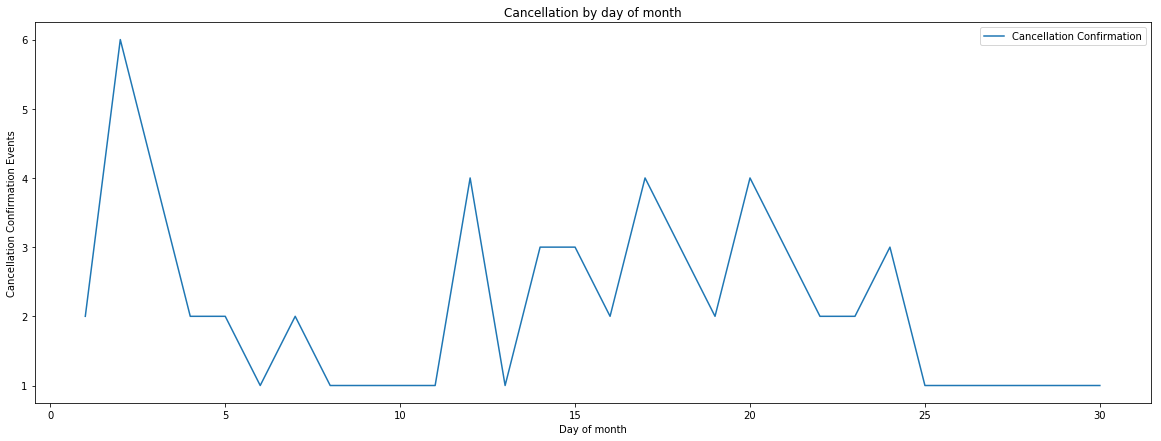

In [63]:
# Check the evolution of Cancellation events over time : day of month

dayOfMonth_count = df.filter(df['page'] == 'Cancellation Confirmation').groupby("day").count().sort('day').toPandas()


# Plot the occurence of Cancelation events over day of month

plt.figure(figsize=(20, 7))
ax = sns.lineplot(x = "day", y = "count", data = dayOfMonth_count)
ax.legend(labels=["Cancellation Confirmation"])
ax.set_title("Cancellation by day of month")
ax.set_xlabel("Day of month")
ax.set_ylabel("Cancellation Confirmation Events");

In [67]:
# Get Weekday Function
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))

# Create Weekday column
df = df.withColumn("weekday", get_weekday(df.ts))

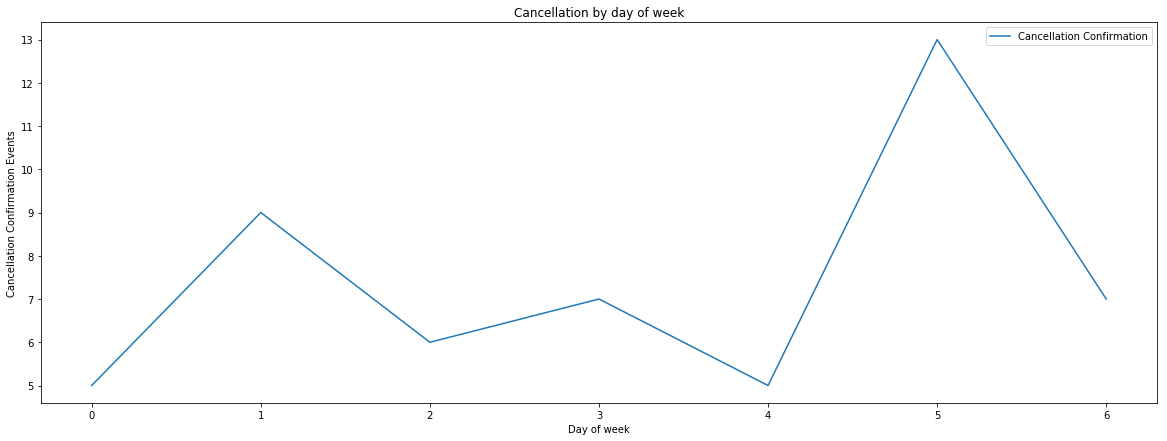

In [68]:
# Check the evolution of Cancellation events over time : day of week

dayOfWeek_count = df.filter(df['page'] == 'Cancellation Confirmation').groupby("weekday").count().sort('weekday').toPandas()


# Plot the occurence of Cancelation events over day of week

plt.figure(figsize=(20, 7))
ax = sns.lineplot(x = "weekday", y = "count", data = dayOfWeek_count)
ax.legend(labels=["Cancellation Confirmation"])
ax.set_title("Cancellation by day of week")
ax.set_xlabel("Day of week")
ax.set_ylabel("Cancellation Confirmation Events");

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.